In [1]:
cd /Users/vivekchaudhary/Data/Big Mart

/Users/vivekchaudhary/Data/Big Mart


# BIG MART SALES PREDICTIONS

### The data can be downloaded from: http://datahack.analyticsvidhya.com/contest/practice-problem-bigmart-sales-prediction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from scipy.stats import boxcox, norm, skew, probplot

from sklearn.preprocessing import StandardScaler, scale, LabelEncoder
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
plt.style.use('fivethirtyeight')

In [3]:
df_train= pd.read_csv("Train_UWu5bXk.csv")  #loading the training data

df_test= pd.read_csv("Test_u94Q5KV.csv")   #loading the test data


df_train['source']= "train"

df_test['source']= "test"


#combining training and test data
data= pd.concat([df_train,df_test], ignore_index= True)  

data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.809,3735.138,Dairy,0.016,9.300,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.269,443.423,Soft Drinks,0.019,5.920,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.618,2097.270,Meat,0.017,17.500,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.095,732.380,Fruits and Vegetables,0.000,19.200,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.861,994.705,Household,0.000,8.930,1987,OUT013,Tier 3,High,Supermarket Type1,train


#### Looking the distribution of the target

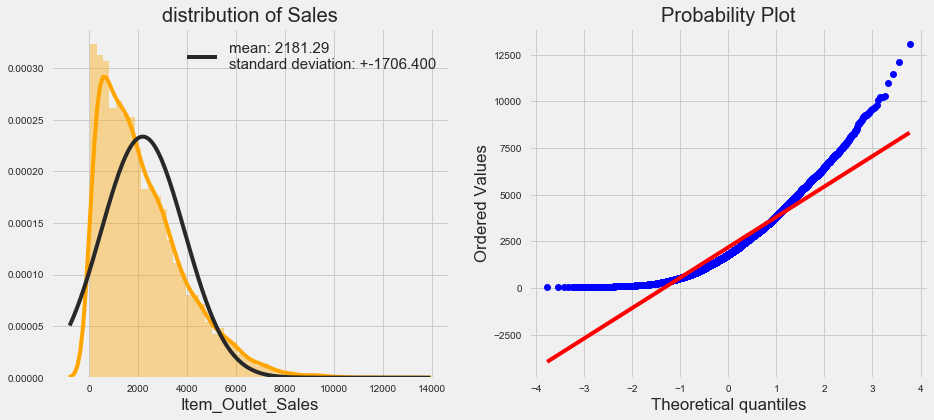

In [4]:
fig, ax = plt.subplots(1,2,figsize= (14,6))

sns.distplot(df_train['Item_Outlet_Sales'], color= 'orange', fit = norm, ax= ax[0])

ax[0].set_title('distribution of Sales')

mu, sigma= norm.fit(df_train['Item_Outlet_Sales'])
ax[0].legend(['mean: %.2f\nstandard deviation: +-%.3f'%(mu, sigma)], loc= 'best', fontsize= 15)


#probability plot

probplot(df_train['Item_Outlet_Sales'], plot= plt)

plt.show()



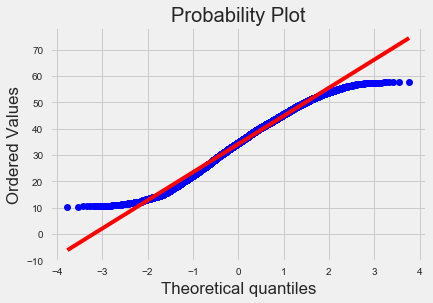

In [5]:
#taking log(1+x) of the target to adjust the skewness of the target

from scipy.special import boxcox

lam= .34
y= boxcox(df_train['Item_Outlet_Sales'], lam)

llimit, ulimit= np.percentile(y,[1, 99] )

#removing the outliers
y= y[(y>llimit) & (y < ulimit)]


probplot(y, plot= plt)
plt.show()

In [6]:
data[data==0]= np.nan   #no column of the dataframe can have zero value, so any zero value will be a null value

print(data.isnull().sum())

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility               879
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64


In [7]:
data.apply(lambda x: len(x.unique()))   #number of unique items in each column

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [8]:
# numerical description of the data

data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000,8523.000,13325.000,11765.000,14204.000
mean,141.005,2181.289,0.070,12.793,1997.831
std,62.087,1706.500,0.050,4.653,8.372
min,31.290,33.290,0.004,4.555,1985.000
25%,94.012,834.247,0.031,8.710,1987.000
50%,142.247,1794.331,0.058,12.600,1999.000
75%,185.856,3101.296,0.098,16.750,2004.000
max,266.888,13086.965,0.328,21.350,2009.000


In [9]:
# filtering the categorical features
categorical_features= [x for x in data.dtypes.index if data[x].dtype=="object"]

# removing the item_id, source and outlet_id
categorical_columns= [x for x in categorical_features if x not in ['Item_Identifier','Outlet_Identifier','source']]

#printing the frequency of the feautures
for col in categorical_columns:
    print("\nthe frequency of different items\n%s"%data[col].value_counts())
    


the frequency of different items
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

the frequency of different items
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

the frequency of different items
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

the frequency of different items
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

the frequency of different items
Supermarket Type1    9294
Grocery Store 

# DATA CLEANING


### IMPUTING MISSING VALUES:

In [10]:

data['Outlet_Size']= data.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0]))

data['Item_Weight']= data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.median()))


data['Item_Visibility']= data.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.fillna(x.median()))


# the null values for item_sales in the dataframe belong to the test data, so there is no need to deal with that

## Feature Engineering

In [11]:

# Item combined type(parsing the item identifier)

data['item_combined_type']= data['Item_Identifier'].apply(lambda x: x[:2])


data['item_combined_type']= data['item_combined_type'].map({"FD":"Food",
                                                           "NC":"Non-consumable",
                                                           "DR":"Drinks"})



In [12]:
# Years of operation of the stores

data['years_of_operation']= 2013 - data['Outlet_Establishment_Year']



In [13]:
# Normalizing the fat content column

data['Item_Fat_Content'].unique()

data['Item_Fat_Content']= data['Item_Fat_Content'].replace({"low fat":"Low Fat",
                                                           "LF":"Low Fat",
                                                           "reg":"Regular"})

data.loc[data['item_combined_type']=="Non-consumable", "Item_Fat_Content"]= "non-edible"

In [14]:
# Label encoding the categorical features

le = LabelEncoder()


data['Outlet']= le.fit_transform(data['Outlet_Identifier'])

cats= ['Item_Fat_Content','Outlet',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type',
       'item_combined_type']

for col in cats:
    data[col]= le.fit_transform(data[col])

In [15]:

data= pd.get_dummies(data, columns=['Item_Fat_Content', 'Outlet', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'item_combined_type'])




In [17]:
data.drop(['Item_Type','Outlet_Establishment_Year'], axis= 1, inplace= True)  #removing the redundant columns from the dataframe

train= data[data['source']== "train"]
test= data[data['source']== "test"]


test.drop(['Item_Outlet_Sales','source'], axis= 1, inplace= True)
train.drop(['source'], axis= 1, inplace= True)

In [18]:
train.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,years_of_operation,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,...,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,item_combined_type_0,item_combined_type_1,item_combined_type_2
0,FDA15,249.809,3735.138,0.016,9.300,OUT049,14,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,DRC01,48.269,443.423,0.019,5.920,OUT018,4,0,1,0,...,0,0,1,0,0,1,0,1,0,0
2,FDN15,141.618,2097.270,0.017,17.500,OUT049,14,1,0,0,...,1,0,0,0,1,0,0,0,1,0
3,FDX07,182.095,732.380,0.023,19.200,OUT010,15,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,NCD19,53.861,994.705,0.013,8.930,OUT013,26,0,0,1,...,0,0,1,0,1,0,0,0,0,1


## MODELLING

In [19]:
# BASE MODEL

base1= df_train[['Item_Identifier',"Outlet_Identifier"]]
base1['Item_Outlet_Sales']= np.mean(df_train['Item_Outlet_Sales'])

base_pred= base1.to_csv("alg0.csv", index= False)



In [20]:
from sklearn import metrics, cross_validation

col_id= ['Item_Identifier', 'Outlet_Identifier']

target= "Item_Outlet_Sales"

def modelfit(alg, train, test,predictors, target, col_id, filename):
    
    # algorithm fit
    alg.fit(train[predictors], train[target])
    
    train_pred = alg.predict(train[predictors])
    
    #cross validation
    
    cv_score= cross_validation.cross_val_score(alg, train[predictors], train[target], cv= 20, scoring= "mean_squared_error")
    
    cv_score= np.sqrt(np.abs(cv_score))
    
    #model report
    
    print("\nMODEL REPORT:")
    
    print("RMSE:%.4f"%(np.sqrt(metrics.mean_squared_error(train[target].values, train_pred))))
    
    print("CV Score : Mean - %.4f | Std - %.4f | Min - %.4f | Max - %.4f"%(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    
    #exporting the predictions
    test[target]= alg.predict(test[predictors])
    
    col_id.append(target)
    
    df_pred= pd.DataFrame({x: test[x] for x in col_id})
    df_pred.to_csv(filename, index= False)
    
    

## 1. Linear Regression


MODEL REPORT:
RMSE:1127.4399
CV Score : Mean - 1128.8424 | Std - 43.5722 | Min - 1074.8548 | Max - 1211.8789


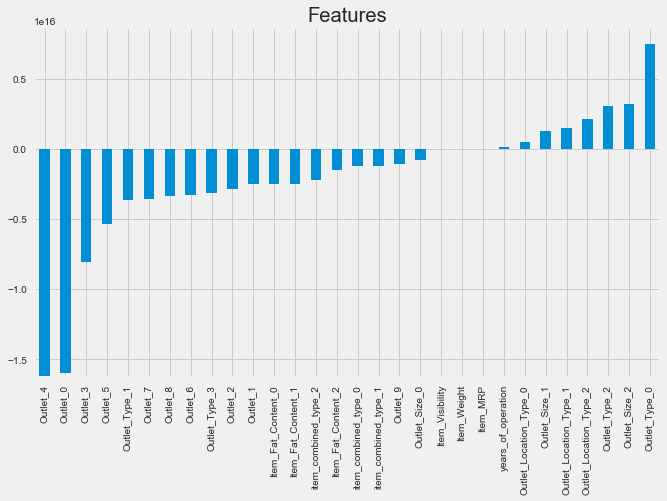

In [21]:
from sklearn.linear_model import LinearRegression, Ridge

lr= LinearRegression(normalize= True)

predictors= [x for x in train.columns if x not in [target]+col_id]

modelfit(lr, train, test, predictors, target, col_id, "alg1.csv")
coef= pd.Series(lr.coef_, predictors).sort_values()

plt.figure(figsize= (10,6))
coef.plot(kind= 'bar', title= "Features")




## 2. Ridge


MODEL REPORT:
RMSE:1127.4769
CV Score : Mean - 1128.7690 | Std - 43.6540 | Min - 1074.7143 | Max - 1211.3269


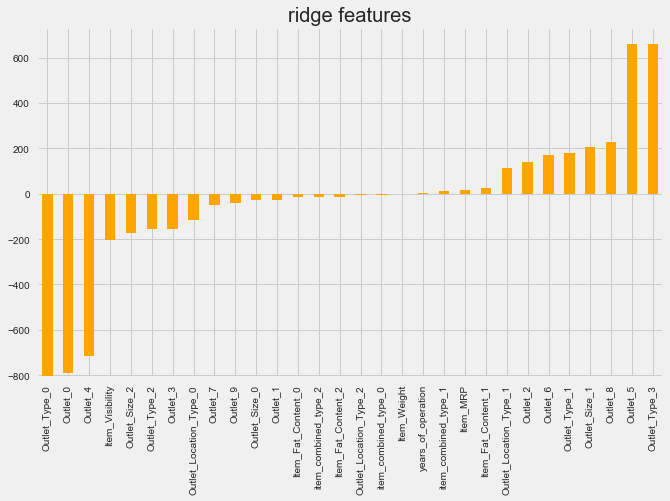

In [22]:
ridge= Ridge(alpha= .01, normalize= True)

predictors= [x for x in train.columns if x not in col_id+[target]]

modelfit(ridge, train, test, predictors, target,col_id, "alg2.csv")

coef2= pd.Series(ridge.coef_, predictors).sort_values()

plt.figure(figsize= (10,6))
coef2.plot(kind= 'bar', title= "ridge features",color= "orange")

## 3. Decision Tree


MODEL REPORT:
RMSE:1059.6698
CV Score : Mean - 1090.4704 | Std - 44.5749 | Min - 999.7325 | Max - 1179.7442


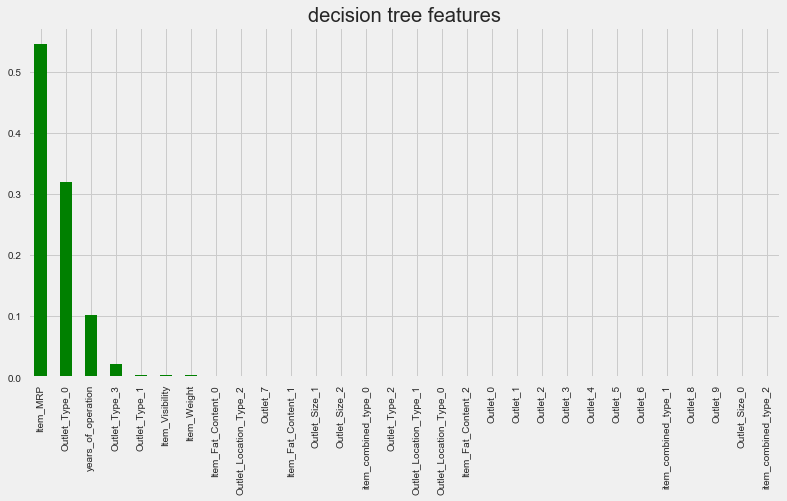

In [23]:
from sklearn.tree import DecisionTreeRegressor

tr= DecisionTreeRegressor(max_depth= 15, min_samples_leaf= 100)
predictors= [x for x in train.columns if x not in col_id+[target]]

modelfit(tr, train, test, predictors, target, col_id, "alg3.csv")

coef3= pd.Series(tr.feature_importances_, predictors).sort_values(ascending= False)

plt.figure(figsize= (12,6))
coef3.plot(kind= "bar", title= "decision tree features", color= "green")

## 4. Random Forest



MODEL REPORT:
RMSE:1068.0908
CV Score : Mean - 1082.3081 | Std - 43.1648 | Min - 1021.3027 | Max - 1158.4460


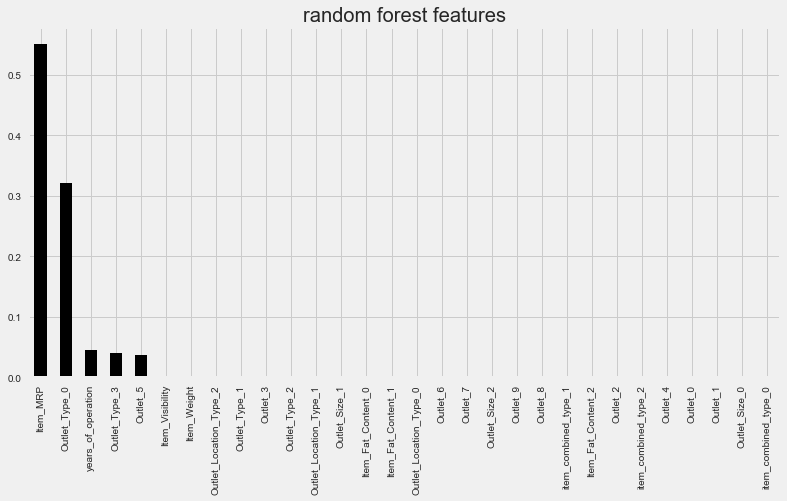

In [24]:
from sklearn.ensemble import RandomForestRegressor

predictors= [x for x in train.columns if x not in col_id+[target]]

rf= RandomForestRegressor(n_estimators= 700, max_depth= 6, min_samples_leaf= 100, n_jobs= 4)

modelfit(rf, train, test, predictors, target, col_id, "alg4.csv")

coef4= pd.Series(rf.feature_importances_, predictors).sort_values(ascending= False)

plt.figure(figsize= (12,6))

coef4.plot(kind= "bar", title= "random forest features",color= "black")